# Big Data Final Project

## Papers Data Set

## Libraries 

In [4]:
#import statements
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF, StopWordsRemover
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from nltk.corpus import stopwords
import re as re

from pyspark.ml.linalg import Vector, Vectors, SparseVector
from pyspark.ml.clustering import LDA, LDAModel

In [6]:
spark = SparkSession.builder.enableHiveSupport().appName('Modeling').getOrCreate()
sc = spark.sparkContext

22/11/28 05:01:53 WARN Utils: Your hostname, betelgeuse resolves to a loopback address: 127.0.1.1; using 10.0.0.130 instead (on interface wlp0s20f3)
22/11/28 05:01:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/28 05:01:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
df = spark.read.csv("/media/betelgeuse/Windows 10/Users/Manish Sihag/Desktop/UChicago/Classes/MSCA31013-Big-Data-Platforms/project/parsed_papers_1k.csv",
                    inferSchema=True, header=True,
                    multiLine=True, quote='\"', escape='\"')
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- journal: string (nullable = true)



## Data Read

In [3]:
%time 
df = spark.read.csv("cord19/csvs/parsed_data.csv", inferSchema=True, header=True)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 16 µs


In [4]:
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- arxiv_id: double (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)



In [5]:
df.show(5)

+----------+--------+-----------------+--------------------+----------+---------+------------+--------------------+--------+--------------------+--------------+--------------------+--------------------+--------------------+
|  paper_id|cord_uid|         source_x|                 doi|     pmcid|pubmed_id|publish_time|             journal|arxiv_id|      pdf_json_files|pmc_json_files|               title|            abstract|             authors|
+----------+--------+-----------------+--------------------+----------+---------+------------+--------------------+--------+--------------------+--------------+--------------------+--------------------+--------------------+
|PMC8202122|lrrd1riz|     Medline; PMC| 10.1200/op.20.00815|PMC8202122| 33434450|  2021-01-12|     JCO Oncol Pract|    null|ef7ee773c2b1f1c54...|    PMC8202122|Telemedicine in C...|COVID-19 places u...|Patt, Debra A.; W...|
|PMC8210641|i36mbtu5|Medline; PMC; WHO|10.1590/1677-5449...|PMC8210641| 34188671|  2021-06-11|Jornal vas

In [8]:
# limiting to abstract column

abstract_data = df[~df["abstract"].isNull()].select("abstract")
abstract_data.show(5)

+--------------------+
|            abstract|
+--------------------+
|OBJECTIVE: This r...|
|Inflammatory dise...|
|Surfactant protei...|
|Endothelin-1 (ET-...|
|Respiratory syncy...|
+--------------------+
only showing top 5 rows



In [6]:
abstract_data.count()

88141

In [9]:
# lowercasing the column

abstract_data = abstract_data.withColumn("abstract", F.lower(F.col('abstract')))
abstract_data.show(5)

+--------------------+
|            abstract|
+--------------------+
|objective: this r...|
|inflammatory dise...|
|surfactant protei...|
|endothelin-1 (et-...|
|respiratory syncy...|
+--------------------+
only showing top 5 rows



In [10]:
# tokenizing the column

abstract_data = abstract_data.withColumn('tokens',F.split(F.trim(F.col('abstract')), " "))
abstract_data.show()

+--------------------+--------------------+
|            abstract|              tokens|
+--------------------+--------------------+
|objective: this r...|[objective:, this...|
|inflammatory dise...|[inflammatory, di...|
|surfactant protei...|[surfactant, prot...|
|endothelin-1 (et-...|[endothelin-1, (e...|
|respiratory syncy...|[respiratory, syn...|
|nidovirus subgeno...|[nidovirus, subge...|
|recent evidence s...|[recent, evidence...|
|the 21st internat...|[the, 21st, inter...|
|heme oxygenase-1 ...|[heme, oxygenase-...|
|this report descr...|[this, report, de...|
|regulation of orn...|[regulation, of, ...|
|heterogeneous nuc...|[heterogeneous, n...|
|the uba domain is...|[the, uba, domain...|
|we examined the r...|[we, examined, th...|
|there are hundred...|[there, are, hund...|
|introduction: the...|[introduction:, t...|
|background: previ...|[background:, pre...|
|background: oxyge...|[background:, oxy...|
|background: alkb-...|[background:, alk...|
|in the 1980's and...|[in, the, 

In [11]:
# creating a list of stopwords

StopWords_list = stopwords.words("english")
StopWords_list[:5]

['i', 'me', 'my', 'myself', 'we']

In [12]:
# removing the stop words

remover = StopWordsRemover(stopWords=StopWords_list, inputCol="tokens", outputCol="filtered")
abstract_data = remover.transform(abstract_data)
abstract_data.show()

+--------------------+--------------------+--------------------+
|            abstract|              tokens|            filtered|
+--------------------+--------------------+--------------------+
|objective: this r...|[objective:, this...|[objective:, retr...|
|inflammatory dise...|[inflammatory, di...|[inflammatory, di...|
|surfactant protei...|[surfactant, prot...|[surfactant, prot...|
|endothelin-1 (et-...|[endothelin-1, (e...|[endothelin-1, (e...|
|respiratory syncy...|[respiratory, syn...|[respiratory, syn...|
|nidovirus subgeno...|[nidovirus, subge...|[nidovirus, subge...|
|recent evidence s...|[recent, evidence...|[recent, evidence...|
|the 21st internat...|[the, 21st, inter...|[21st, internatio...|
|heme oxygenase-1 ...|[heme, oxygenase-...|[heme, oxygenase-...|
|this report descr...|[this, report, de...|[report, describe...|
|regulation of orn...|[regulation, of, ...|[regulation, orni...|
|heterogeneous nuc...|[heterogeneous, n...|[heterogeneous, n...|
|the uba domain is...|[th

In [13]:
## Tokenizers

df_txts = abstract_data.select("filtered")

# TF
cv = CountVectorizer(inputCol="filtered", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)

# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [17]:
result_tfidf.show(5)

+--------------------+--------------------+--------------------+
|            filtered|        raw_features|            features|
+--------------------+--------------------+--------------------+
|[objective:, retr...|(1984,[5,6,13,17,...|(1984,[5,6,13,17,...|
|[inflammatory, di...|(1984,[8,20,22,34...|(1984,[8,20,22,34...|
|[surfactant, prot...|(1984,[3,4,9,20,2...|(1984,[3,4,9,20,2...|
|[endothelin-1, (e...|(1984,[11,28,42,5...|(1984,[11,28,42,5...|
|[respiratory, syn...|(1984,[1,2,3,6,22...|(1984,[1,2,3,6,22...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
xx = result_tfidf.toPandas().head()
xx

,filtered,raw_features,features
0,"[objective:, retrospective, chart, review, des...","(0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 1.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 19.496190938298188, ..."
1,"[inflammatory, diseases, respiratory, tract, c...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.507..."
2,"[surfactant, protein-d, (sp-d), participates, ...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.6053269097275782, 1.33314902..."
3,"[endothelin-1, (et-1), 21, amino, acid, peptid...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[respiratory, syncytial, virus, (rsv), pneumon...","(0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 2.2578669647661433, 1.4846989219389635, ..."


In [29]:
from wordcloud import WordCloud

In [38]:
corpus_dict = {cvmodel.vocabulary[i]: idfModel.idf[i] for i in range(len(idfModel.idf))}
len(corpus_dict)

1984

In [40]:
import matplotlib.pyplot as plt

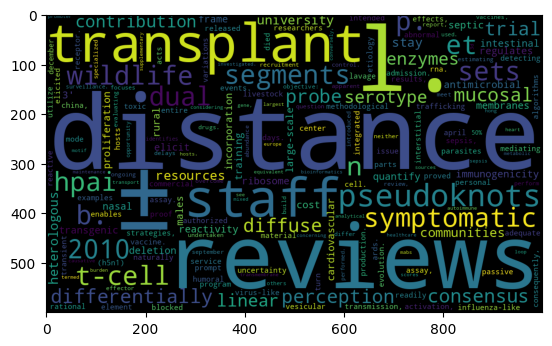

In [41]:
wordcloud = WordCloud(width=1000, height=600).generate_from_frequencies(corpus_dict)
plt.imshow(wordcloud)

In [16]:
xx.features[1]

SparseVector(1984, {8: 1.5077, 20: 1.6965, 22: 3.961, 34: 2.058, 58: 2.6736, 64: 2.1162, 82: 1.9805, 113: 2.2149, 118: 4.757, 129: 2.314, 133: 2.6298, 151: 4.6915, 155: 2.424, 156: 2.4963, 164: 4.9432, 165: 2.4963, 185: 2.5216, 211: 5.7059, 221: 2.6736, 230: 2.6887, 279: 2.9465, 354: 2.9663, 501: 3.2148, 565: 3.2948, 596: 3.352, 609: 3.5461, 655: 3.4443, 726: 3.4443, 748: 3.6595, 849: 3.7003, 853: 3.6202, 884: 3.7428, 889: 3.7873, 965: 3.8338, 1090: 3.9339, 1140: 3.8826, 1287: 3.9339, 1481: 8.9609, 1524: 4.3134, 1610: 4.3134, 1611: 4.1703, 1729: 4.3934, 1845: 4.3934, 1944: 4.4804})

In [18]:
xx.features[0]

SparseVector(1984, {5: 19.4962, 6: 1.4316, 13: 1.4622, 17: 2.4963, 19: 1.4534, 20: 1.6965, 22: 3.961, 24: 1.8811, 40: 1.6105, 52: 1.9583, 80: 1.9657, 95: 1.9583, 101: 2.4963, 124: 2.1509, 125: 2.4839, 129: 2.314, 136: 7.2373, 139: 2.6017, 140: 6.0564, 160: 12.6726, 165: 2.4963, 171: 2.4716, 174: 2.6588, 175: 2.6442, 178: 2.6736, 198: 2.5216, 203: 12.4685, 262: 3.0282, 276: 2.8179, 282: 9.0845, 292: 3.511, 316: 2.9865, 395: 3.0497, 426: 3.2407, 519: 3.2674, 534: 3.2674, 552: 3.6595, 619: 3.5825, 646: 3.352, 758: 3.4771, 889: 3.7873, 950: 3.7003, 958: 3.7428, 1039: 3.8826, 1171: 3.988, 1237: 3.988, 1238: 3.8826, 1288: 8.2115, 1303: 4.2393, 1359: 4.1057, 1449: 8.7868, 1498: 4.3934, 1523: 4.1057, 1549: 4.3134, 1558: 4.4804, 1719: 13.4413, 1722: 4.2393, 1736: 4.4804, 1737: 4.3134, 1759: 4.3134, 1819: 8.7868, 1925: 4.4804, 1950: 4.4804})

In [19]:
num_topics = 10
max_iterations = 10

lda = LDA(k=num_topics, seed=1, optimizer="em")
lda.setMaxIter(max_iterations)
lda_model = lda.fit(result_tfidf[['features']])

In [20]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1, 4, 0, 3, 15, ...|[0.00297806848685...|
|    1|[1, 4, 0, 3, 15, ...|[0.00313537178619...|
|    2|[1, 4, 0, 3, 15, ...|[0.00293632135738...|
|    3|[1, 4, 0, 3, 15, ...|[0.00310664381243...|
|    4|[1, 4, 0, 3, 15, ...|[0.00322066596079...|
|    5|[1, 4, 0, 3, 15, ...|[0.00330707656838...|
|    6|[1, 4, 0, 3, 15, ...|[0.00315643273333...|
|    7|[1, 4, 0, 3, 15, ...|[0.00334367422854...|
|    8|[1, 4, 0, 3, 15, ...|[0.00325107769251...|
|    9|[1, 4, 0, 1207, 3...|[0.00326304135813...|
+-----+--------------------+--------------------+



In [21]:
vocab = cvmodel.vocabulary

def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]

udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

In [22]:
num_top_words = 10

topics = lda_model\
     .describeTopics(num_top_words)\
     .withColumn('topicWords', udf_to_words(F.col('termIndices')))

        
topics.select('topic', 'topicWords').show(truncate=100)

+-----+------------------------------------------------------------------------------+
|topic|                                                                    topicWords|
+-----+------------------------------------------------------------------------------+
|    0|[patients, =, covid-19, health, sars-cov-2, care, study, data, clinical, risk]|
|    1|       [patients, =, covid-19, health, sars-cov-2, study, p, data, risk, care]|
|    2|[patients, =, covid-19, health, sars-cov-2, study, care, data, pandemic, risk]|
|    3|       [patients, =, covid-19, health, sars-cov-2, study, care, p, risk, data]|
|    4|       [patients, =, covid-19, health, sars-cov-2, p, study, care, risk, data]|
|    5|   [patients, =, covid-19, health, sars-cov-2, p, risk, study, care, clinical]|
|    6|       [patients, =, covid-19, health, sars-cov-2, study, care, data, p, risk]|
|    7|   [patients, =, covid-19, health, sars-cov-2, p, study, care, risk, clinical]|
|    8|   [patients, =, covid-19, health, s

In [17]:
transformed = lda_model.transform(result_tfidf)

In [18]:
transformed.show()

+--------------------+--------------------+--------------------+--------------------+
|            filtered|        raw_features|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+
|[covid-19, places...|(5000,[0,1,3,11,1...|(5000,[0,1,3,11,1...|[0.02862794146688...|
|[background:, pro...|(5000,[0,1,2,12,1...|(5000,[0,1,2,12,1...|[0.04111047637897...|
|[concept, chemica...|(5000,[2,5,6,17,3...|(5000,[2,5,6,17,3...|[0.03731989588944...|
|[type, 1, diabete...|(5000,[3,5,6,7,8,...|(5000,[3,5,6,7,8,...|[0.03808736264410...|
|[data, collected,...|(5000,[0,3,5,11,1...|(5000,[0,3,5,11,1...|[0.03794467958540...|
|[school, closures...|(5000,[0,2,3,5,6,...|(5000,[0,2,3,5,6,...|[0.04539841068745...|
|[abstract:, backg...|(5000,[2,4,6,12,1...|(5000,[2,4,6,12,1...|[0.09599507530996...|
|[background:, glo...|(5000,[0,5,7,9,16...|(5000,[0,5,7,9,16...|[0.31068396206529...|
|[domestic, travel...|(5000,[3,13,14,23...|(5000,[3,13

In [19]:
transformed.select("topicDistribution").show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topicDistribution                                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.028627941466889913,0.4558020065605592,0.040834833306643344,0.059588402356623854,0.038693040568049175,0.023633977077515342,0.03554331154167929,0.1722144737318495,0.11830252802801919,0.026759485362171383]|
|[0.04111047637897062,0.027397290778261862,0.47019148928642984,0.036422595100200295,0.02556185921885773,0.03193340234652348,0.030957450688511776,0.02201277452455759,0.0

In [ ]:
## add meaning to the last column

## can add more data cleaning steps
## use a different tokenizer
## Different topic modeler
## add sentiment?